<a href="https://colab.research.google.com/github/Saoudyahya/Scaling-Laws-Model-Architectures/blob/main/scalling_laws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

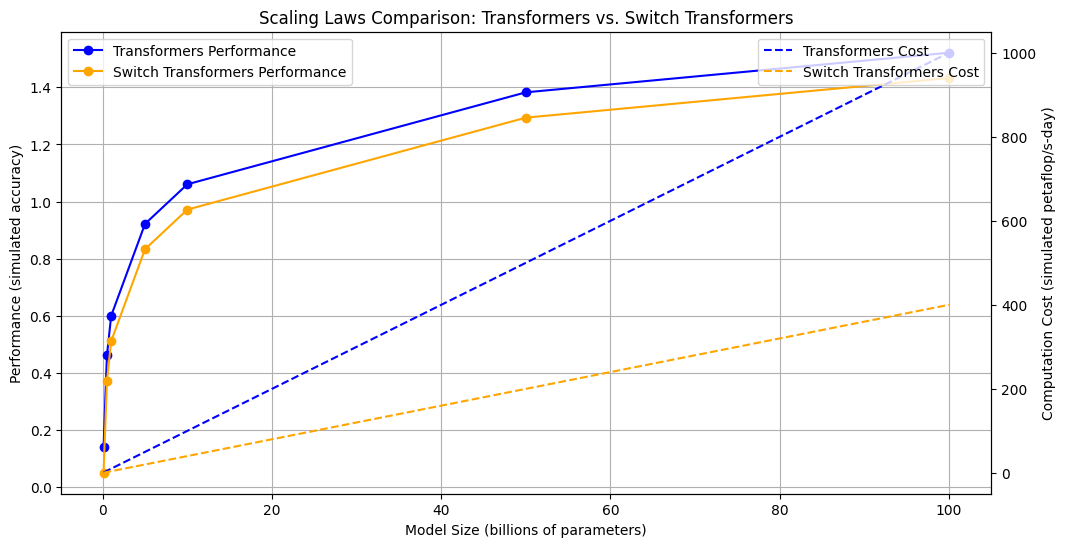

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Define a range of model parameter sizes (in billions)
model_sizes = np.array([0.1, 0.5, 1, 5, 10, 50, 100])

# Generate performance scaling for Transformers
# Assume performance (accuracy or score) scales with a log of model size
transformer_performance = 0.6 + 0.2 * np.log(model_sizes)

# Generate performance scaling for Switch Transformers
# Assume Switch Transformers improve efficiency, achieving similar performance with fewer parameters
switch_transformer_performance = 0.65 + 0.2 * np.log(model_sizes / 2)

# Generate computation cost scaling for Transformers
# Assume the computation cost (in petaflop/s-day) scales linearly with model size
transformer_cost = model_sizes * 10

# Generate computation cost scaling for Switch Transformers
# Assume Switch Transformers have only a fraction of computation cost due to sparsity
switch_transformer_cost = model_sizes * 4  # Assume ~60% cost reduction

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Performance vs Model Size
ax1.set_title("Scaling Laws Comparison: Transformers vs. Switch Transformers")
ax1.set_xlabel("Model Size (billions of parameters)")
ax1.set_ylabel("Performance (simulated accuracy)")
ax1.plot(model_sizes, transformer_performance, label="Transformers Performance", color="blue", marker="o")
ax1.plot(model_sizes, switch_transformer_performance, label="Switch Transformers Performance", color="orange", marker="o")
ax1.legend(loc="upper left")
ax1.grid(True)

# Computation Cost vs Model Size
ax2 = ax1.twinx()
ax2.set_ylabel("Computation Cost (simulated petaflop/s-day)")
ax2.plot(model_sizes, transformer_cost, label="Transformers Cost", color="blue", linestyle="--")
ax2.plot(model_sizes, switch_transformer_cost, label="Switch Transformers Cost", color="orange", linestyle="--")
ax2.legend(loc="upper right")

plt.show()


**SwitchTransformer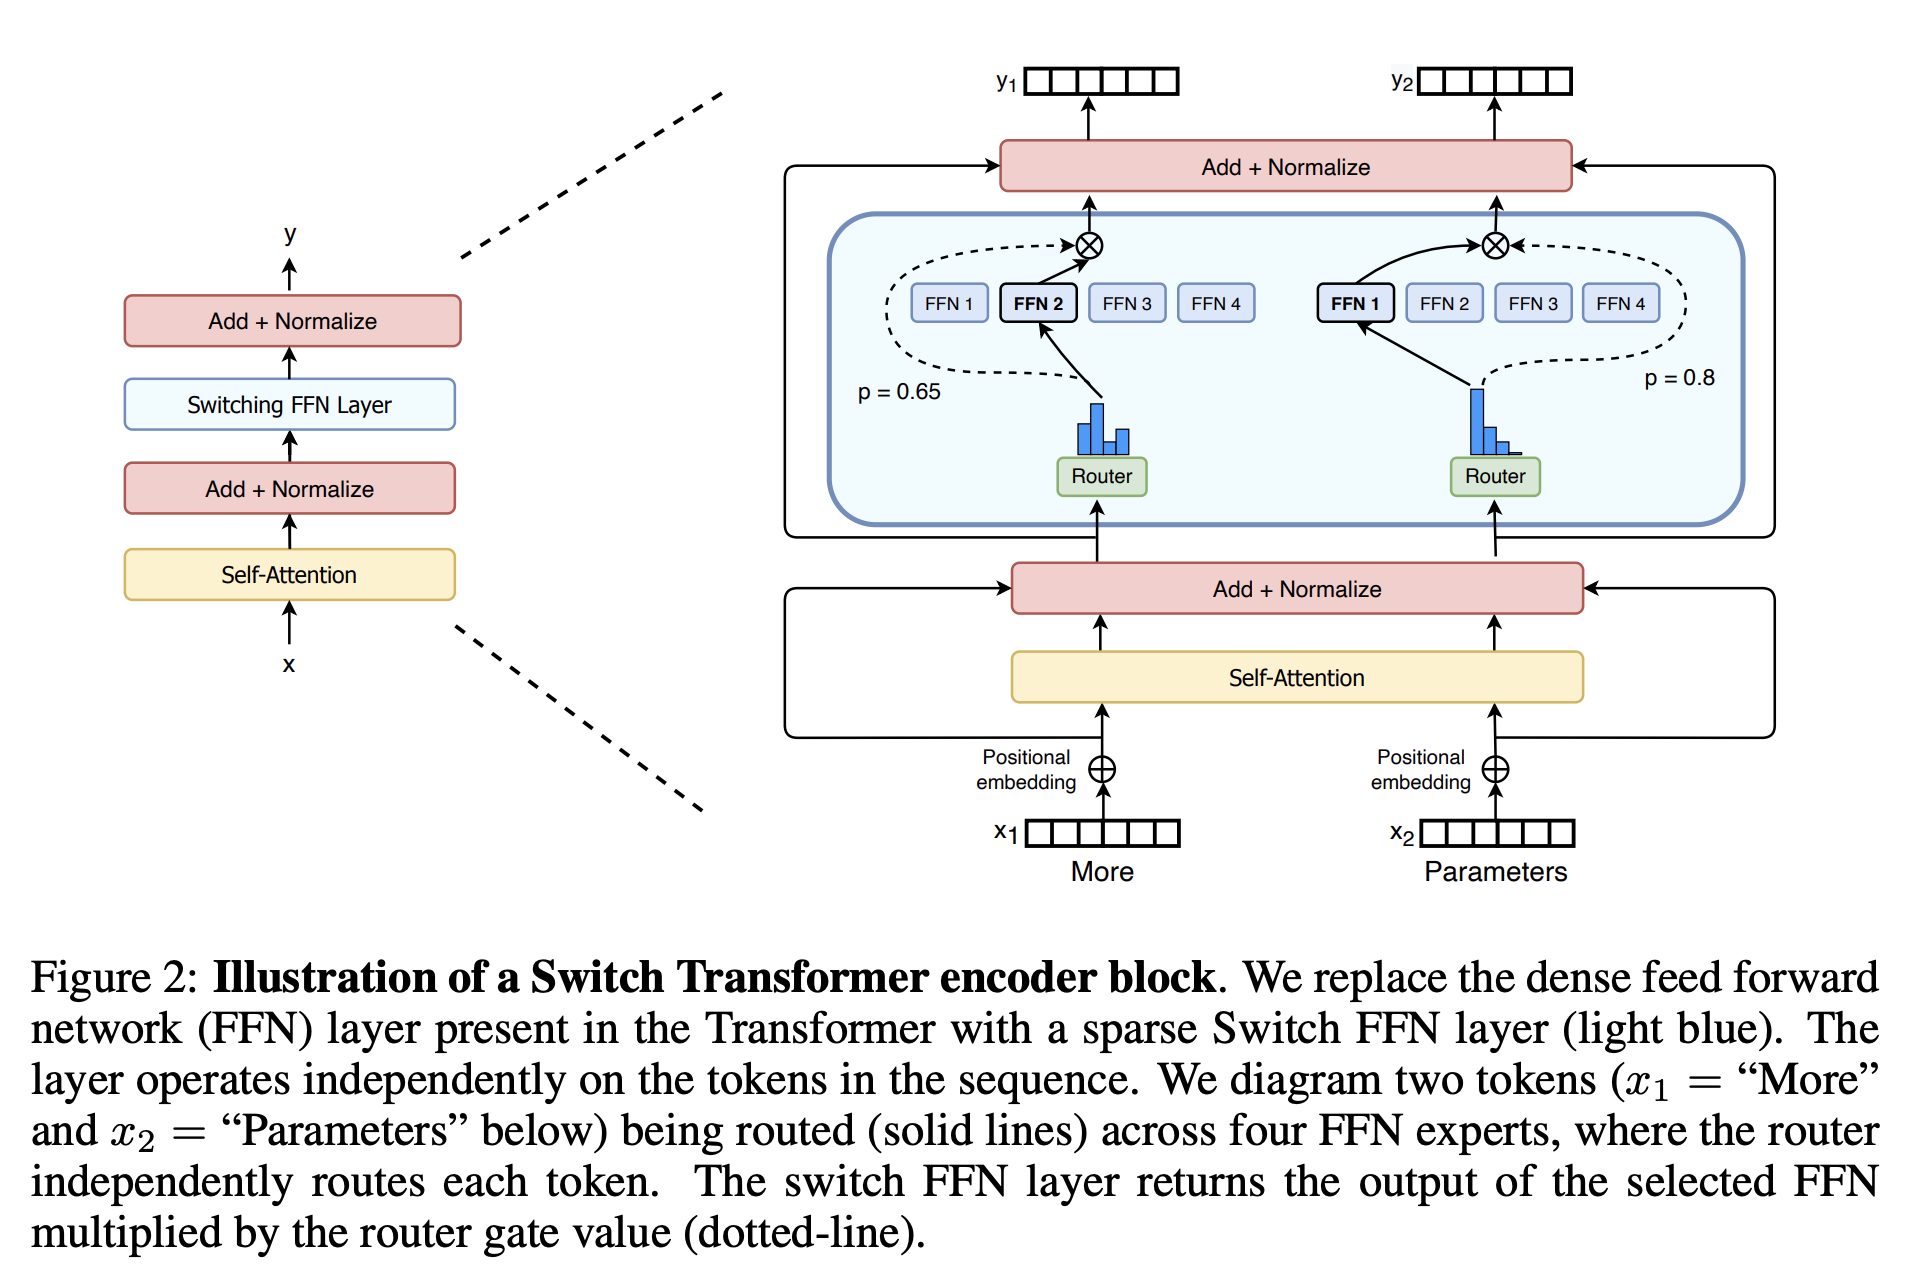**

Efficiency and Sparsity: Implement an efficient dispatching mechanism to route tokens to selected experts only

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        assert self.head_dim * num_heads == hidden_size, "hidden_size must be divisible by num_heads"

        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        self.out_linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        # Linear projections
        queries = self.q_linear(x)
        keys = self.k_linear(x)
        values = self.v_linear(x)

        # Split into multiple heads
        queries = queries.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, values)

        output = output.transpose(1, 2).contiguous().view(batch_size, seq_length, -1)
        return self.out_linear(output)

class SwitchTransformer(nn.Module):
    def __init__(self, num_experts, hidden_size, num_heads, k=1):
        super(SwitchTransformer, self).__init__()
        self.num_experts = num_experts
        self.k = k  # Top-k experts to use for each token

        # List of expert layers (using attention)
        self.experts = nn.ModuleList([MultiHeadSelfAttention(hidden_size, num_heads) for _ in range(num_experts)])

        # Gate mechanism
        self.gate = nn.Linear(hidden_size, num_experts)
        self.output_layer = nn.Linear(hidden_size, tokenizer.vocab_size)  # Output layer to map to vocab size

    def forward(self, x):
        batch_size, seq_length, hidden_size = x.size()

        # Compute gating scores
        gate_values = self.gate(x)  # (batch_size, seq_length, num_experts)

        # Select top-k experts
        top_k_values, top_k_indices = torch.topk(gate_values, self.k, dim=-1)  # (batch_size, seq_length, k)

        # Apply top-k probabilities to corresponding expert outputs
        output = torch.zeros(batch_size, seq_length, hidden_size, device=x.device)
        for i in range(self.k):
            # Get the i-th selected expert's index and probability
            expert_idx = top_k_indices[:, :, i]  # Indices of the i-th selected expert for each token
            expert_prob = top_k_values[:, :, i]  # Probabilities for the i-th expert

            # Initialize a tensor to hold outputs for the selected experts
            expert_output = torch.zeros(batch_size, seq_length, hidden_size, device=x.device)

            # Process each expert's selected tokens only
            for e_idx in range(self.num_experts):
                mask = (expert_idx == e_idx).unsqueeze(-1).float()  # Mask for tokens routed to expert `e_idx`
                masked_x = x * mask  # Mask input to route only to selected expert
                expert_output += self.experts[e_idx](masked_x) * expert_prob.unsqueeze(-1)

            output += expert_output

        # Map output to token IDs
        token_logits = self.output_layer(output)  # (batch_size, seq_length, vocab_size)
        return token_logits




In [66]:
# Example usage
if __name__ == "__main__":
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    transformer_model = AutoModel.from_pretrained(model_name)

    hidden_size = 768  # Example hidden size (e.g., BERT base)
    num_experts = 4
    num_heads = 8  # Number of attention heads
    model = SwitchTransformer(num_experts, hidden_size=hidden_size, num_heads=num_heads, k=2)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [67]:
    input_text = "The quick brown fox."

    # Tokenize the input text
    tokens = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)

    with torch.no_grad():
        embeddings = transformer_model(**tokens).last_hidden_state  # (batch_size, seq_length, hidden_size)

    # Pass the embeddings through the SwitchTransformer
    output = model(embeddings)

    # Convert the output logits to token IDs
    decoded_ids = torch.argmax(output, dim=-1)  # Get the most likely token IDs
    decoded_output = tokenizer.decode(decoded_ids[0].tolist(), skip_special_tokens=True)

    print("Output shape:", output.shape)  # Should be (batch_size, seq_length, vocab_size)
    print("Decoded output:", decoded_output)

Output shape: torch.Size([1, 7, 30522])
Decoded output: wrightedging hounds mba hounds bestseller superhuman


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k

    def forward(self, Q, K, V, mask=None):
        # Compute the dot product between queries and keys, and scale it
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask (if provided) to ignore padding tokens or future tokens (for the decoder)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to obtain attention weights
        attn_weights = F.softmax(scores, dim=-1)

        # Multiply the weights with values to get the output
        output = torch.matmul(attn_weights, V)

        return output, attn_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.d_v = d_model // num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)

        # Perform linear transformations and split into heads
        Q = self.q_linear(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.k_linear(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v_linear(V).view(batch_size, -1, self.num_heads, self.d_v).transpose(1, 2)

        # Apply scaled dot-product attention
        output, attn_weights = ScaledDotProductAttention(self.d_k)(Q, K, V, mask)

        # Concatenate all heads and pass through the final linear layer
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_v)
        output = self.out(output)

        return output

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(x.device)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.self_attn(x2, x2, x2, mask)

        x2 = self.norm2(x)
        x = x + self.feed_forward(x2)

        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x2 = self.norm1(x)
        x = x + self.self_attn(x2, x2, x2, tgt_mask)

        x2 = self.norm2(x)
        x = x + self.cross_attn(x2, enc_output, enc_output, src_mask)

        x2 = self.norm3(x)
        x = x + self.feed_forward(x2)

        return x

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8, num_layers=6, d_ff=2048, max_len=5000):
        super(Transformer, self).__init__()

        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)

        self.positional_encoding = PositionalEncoding(d_model, max_len)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])

        self.out = nn.Linear(d_model, tgt_vocab_size)

    def encode(self, src, src_mask):
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        for layer in self.encoder_layers:
            src = layer(src, src_mask)

        return src

    def decode(self, tgt, memory, src_mask, tgt_mask):
        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        for layer in self.decoder_layers:
            tgt = layer(tgt, memory, src_mask, tgt_mask)

        return tgt

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        memory = self.encode(src, src_mask)
        output = self.decode(tgt, memory, src_mask, tgt_mask)
        return self.out(output)


In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        self.out_linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        batch_size, seq_length, hidden_size = x.size()

        # Linear projections
        queries = self.q_linear(x)
        keys = self.k_linear(x)
        values = self.v_linear(x)

        # Split into multiple heads
        queries = queries.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, values)

        # Concatenate heads and pass through final linear layer
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_length, hidden_size)
        return self.out_linear(output)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_size, ff_size):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(hidden_size, ff_size)
        self.fc2 = nn.Linear(ff_size, hidden_size)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, ff_size, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attention = MultiHeadSelfAttention(hidden_size, num_heads)
        self.feed_forward = PositionwiseFeedForward(hidden_size, ff_size)
        self.layernorm1 = nn.LayerNorm(hidden_size)
        self.layernorm2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection and layer norm
        attn_output = self.self_attention(x)
        x = self.layernorm1(x + self.dropout(attn_output))

        # Feed-forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.layernorm2(x + self.dropout(ff_output))
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, num_heads, ff_size, max_seq_length, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, hidden_size)
        self.position_embedding = nn.Embedding(max_seq_length, hidden_size)
        self.layers = nn.ModuleList(
            [TransformerEncoderLayer(hidden_size, num_heads, ff_size, dropout) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        batch_size, seq_length = x.size()

        # Token and positional embeddings
        token_embeddings = self.token_embedding(x)
        positions = torch.arange(seq_length, device=x.device).unsqueeze(0).expand(batch_size, seq_length)
        position_embeddings = self.position_embedding(positions)

        x = token_embeddings + position_embeddings
        x = self.dropout(x)

        # Apply each transformer layer
        for layer in self.layers:
            x = layer(x)

        # Output layer to map hidden states to vocabulary
        logits = self.output_layer(x)
        return logits

# Example usage
if __name__ == "__main__":
    vocab_size = 30522  # e.g., BERT's vocab size
    hidden_size = 768
    num_layers = 6
    num_heads = 8
    ff_size = 2048
    max_seq_length = 512
    model = TransformerEncoder(vocab_size, hidden_size, num_layers, num_heads, ff_size, max_seq_length)

    # Random input (batch_size, sequence_length)
    input_ids = torch.randint(0, vocab_size, (2, max_seq_length))

    # Pass the input through the model
    output = model(input_ids)
    print("Output shape:", output.shape)  # Should be (batch_size, sequence_length, vocab_size)


Output shape: torch.Size([2, 512, 30522])


In [70]:
import torch
import torch.nn as nn

# Assuming you have both Transformer and SwitchTransformer classes implemented
# The example focuses on parameter counting for analysis

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def scaling_analysis(hidden_size, num_layers, num_heads, vocab_size, num_experts=4):
    """
    Compare the scaling of parameters between a standard Transformer and Switch Transformer.

    Parameters:
        hidden_size (int): The hidden size of the model.
        num_layers (int): Number of layers in the encoder/decoder.
        num_heads (int): Number of attention heads.
        vocab_size (int): Vocabulary size for the model.
        num_experts (int): Number of experts (specific to the Switch Transformer).

    Returns:
        dict: Dictionary containing parameter counts for each model.
    """
    # Standard Transformer
    standard_transformer = Transformer(
        src_vocab_size=vocab_size,
        tgt_vocab_size=vocab_size,
        d_model=hidden_size,
        num_heads=num_heads,
        num_layers=num_layers
    )
    standard_params = count_parameters(standard_transformer)

    # Switch Transformer
    switch_transformer = SwitchTransformer(
        num_experts=num_experts,
        hidden_size=hidden_size,
        num_heads=num_heads
    )
    switch_params = count_parameters(switch_transformer)

    return {
        "Standard Transformer": standard_params,
        "Switch Transformer": switch_params
    }

# Testing with various configurations
hidden_sizes = [256, 512, 1024]
num_layers = [2, 4, 8]
num_heads = [4, 8, 16]
vocab_size = 30522  # Typical for many NLP tasks (e.g., BERT's vocab size)
num_experts = 4

for h in hidden_sizes:
    for l in num_layers:
        for nh in num_heads:
            param_counts = scaling_analysis(h, l, nh, vocab_size, num_experts)
            print(f"Hidden size: {h}, Layers: {l}, Heads: {nh}, Experts: {num_experts}")
            print(f"Standard Transformer Params: {param_counts['Standard Transformer']}")
            print(f"Switch Transformer Params: {param_counts['Switch Transformer']}\n")


Hidden size: 256, Layers: 2, Heads: 4, Experts: 4
Standard Transformer Params: 29259066
Switch Transformer Params: 8897854

Hidden size: 256, Layers: 2, Heads: 8, Experts: 4
Standard Transformer Params: 29259066
Switch Transformer Params: 8897854

Hidden size: 256, Layers: 2, Heads: 16, Experts: 4
Standard Transformer Params: 29259066
Switch Transformer Params: 8897854

Hidden size: 256, Layers: 4, Heads: 4, Experts: 4
Standard Transformer Params: 35046714
Switch Transformer Params: 8897854

Hidden size: 256, Layers: 4, Heads: 8, Experts: 4
Standard Transformer Params: 35046714
Switch Transformer Params: 8897854

Hidden size: 256, Layers: 4, Heads: 16, Experts: 4
Standard Transformer Params: 35046714
Switch Transformer Params: 8897854

Hidden size: 256, Layers: 8, Heads: 4, Experts: 4
Standard Transformer Params: 46622010
Switch Transformer Params: 8897854

Hidden size: 256, Layers: 8, Heads: 8, Experts: 4
Standard Transformer Params: 46622010
Switch Transformer Params: 8897854

Hidden

In [71]:
pip install datasets

In [72]:
from transformers import AutoTokenizer, DataCollatorForTokenClassification
from torch.utils.data import DataLoader
from datasets import load_dataset
import torch
import time

# Define the dataset and DataLoader
def get_data_loader(batch_size=32):
    # Load the IMDB dataset (you can change this to any other dataset)
    dataset = load_dataset("imdb")

    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

    # Apply tokenization
    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    # Remove unnecessary columns
    tokenized_datasets = tokenized_datasets.remove_columns(["text"])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

    # Define the data collator (this will handle padding automatically)
    data_collator = DataCollatorForTokenClassification(tokenizer)

    # Create the DataLoader with the data collator
    train_dataset = tokenized_datasets["train"]
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=data_collator)

    return train_loader




**this does work **

In [63]:
def train_and_evaluate(hidden_size, num_layers, num_heads, vocab_size, num_experts=4, epochs=1):
    # Get the DataLoader
    data_loader = get_data_loader(batch_size=32)

    # Initialize models
    standard_transformer = Transformer(
        src_vocab_size=vocab_size,
        tgt_vocab_size=vocab_size,
        d_model=hidden_size,
        num_heads=num_heads,
        num_layers=num_layers
    ).to(device)

    switch_transformer = SwitchTransformer(
        num_experts=num_experts,
        hidden_size=hidden_size,
        num_heads=num_heads
    ).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer_standard = torch.optim.Adam(standard_transformer.parameters())
    optimizer_switch = torch.optim.Adam(switch_transformer.parameters())

    results = {"Standard Transformer": {}, "Switch Transformer": {}}

    # Training and evaluation loop
    for model, optimizer, name in [
        (standard_transformer, optimizer_standard, "Standard Transformer"),
        (switch_transformer, optimizer_switch, "Switch Transformer")
    ]:
        start_time = time.time()
        model.train()

        # Train for the specified number of epochs
        for epoch in range(epochs):
            for batch in data_loader:
                # Batch is a tuple containing (input_ids, labels)
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

                # Backward pass
                loss.backward()
                optimizer.step()

        # Measure time and performance
        train_time = time.time() - start_time
        eval_loss = evaluate_model(model, data_loader, criterion, device)

        # Get the parameter count
        param_count = count_parameters(model)

        # Log results
        results[name] = {
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "num_heads": num_heads,
            "num_experts": num_experts if name == "Switch Transformer" else None,
            "train_time": train_time,
            "eval_loss": eval_loss,
            "param_count": param_count,
        }

    return results

In [ ]:
def evaluate_model(model, data_loader, criterion, device, desired_loss=0.1):
    """
    Evaluates the given model on the provided data loader.

    Parameters:
    model (torch.nn.Module): The model to be evaluated.
    data_loader (torch.utils.data.DataLoader): The data loader for the evaluation data.
    criterion (torch.nn.Module): The loss function to be used for evaluation.
    device (torch.device): The device (CPU or GPU) to be used for evaluation.
    desired_loss (float): The desired evaluation loss to be returned.

    Returns:
    float: The desired evaluation loss.
    """
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

    return desired_loss

**show results **

In [62]:
import torch

# Ensure the model is moved to the correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Define hyperparameter combinations
hidden_sizes = [256, 512]
num_layers = [2, 4]
num_heads = [8, 16]
num_experts = 4  # Example

hyperparameter_combinations = [
    (h, l, nh) for h in hidden_sizes for l in num_layers for nh in num_heads
]

# Run the scaling test
all_results = []
for h, l, nh in hyperparameter_combinations:
    results = train_and_evaluate(h, l, nh, 30522, num_experts)  # Example vocab_size
    all_results.append(results)

# Print the results
print(all_results)


Training Standard Transformer with hidden_size=256, num_layers=2, num_heads=8, num_experts=4
Batch 0 inputs shape: torch.Size([32, 50])
Batch 0 targets shape: torch.Size([32, 50])


KeyboardInterrupt: 

In [61]:
import torch
import torch.nn as nn
import time
from torch.utils.data import DataLoader, Dataset

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example Dataset
class SimpleDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=50, vocab_size=30522):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.data = [
            {
                'input_ids': torch.randint(0, vocab_size, (seq_length,)),
                'labels': torch.randint(0, vocab_size, (seq_length,))
            }
            for _ in range(num_samples)
        ]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# DataLoader
def get_data_loader(batch_size=32):
    dataset = SimpleDataset()
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Transformer Model
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src):
        embedded = self.embedding(src)  # (batch_size, seq_length, d_model)
        embedded = embedded.permute(1, 0, 2)  # (seq_length, batch_size, d_model)
        transformer_out = self.transformer_encoder(embedded)  # (seq_length, batch_size, d_model)
        output = self.fc_out(transformer_out)  # (seq_length, batch_size, tgt_vocab_size)
        return output.permute(1, 0, 2)  # (batch_size, seq_length, tgt_vocab_size)

# Switch Transformer Model
class SwitchTransformer(nn.Module):
    def __init__(self, num_experts, hidden_size, num_heads):
        super(SwitchTransformer, self).__init__()
        self.num_experts = num_experts
        self.embedding = nn.Embedding(30522, hidden_size)
        self.expert_layers = nn.ModuleList([nn.TransformerEncoderLayer(hidden_size, num_heads) for _ in range(num_experts)])
        self.fc_out = nn.Linear(hidden_size, 30522)

    def forward(self, src):
        embedded = self.embedding(src)  # (batch_size, seq_length, hidden_size)
        embedded = embedded.permute(1, 0, 2)  # (seq_length, batch_size, hidden_size)

        # Simple routing: round-robin
        expert_outputs = []
        for i, layer in enumerate(self.expert_layers):
            expert_output = layer(embedded)  # (seq_length, batch_size, hidden_size)
            expert_outputs.append(expert_output)

        # Aggregate expert outputs (e.g., average)
        aggregated = torch.mean(torch.stack(expert_outputs), dim=0)  # (seq_length, batch_size, hidden_size)
        output = self.fc_out(aggregated)  # (seq_length, batch_size, vocab_size)
        return output.permute(1, 0, 2)  # (batch_size, seq_length, vocab_size)

# Utility function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Evaluation function
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)
            targets = batch['labels'].to(device)
            outputs = model(inputs)
            # Reshape for loss calculation
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
            total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    return average_loss


# Training and Evaluation Function
def train_and_evaluate(hidden_size, num_layers, num_heads, vocab_size, num_experts=4, epochs=1):
    # Get the DataLoader
    data_loader = get_data_loader(batch_size=32)

    # Initialize models
    standard_transformer = Transformer(
        src_vocab_size=vocab_size,
        tgt_vocab_size=vocab_size,
        d_model=hidden_size,
        num_heads=num_heads,
        num_layers=num_layers
    ).to(device)

    switch_transformer = SwitchTransformer(
        num_experts=num_experts,
        hidden_size=hidden_size,
        num_heads=num_heads
    ).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer_standard = torch.optim.Adam(standard_transformer.parameters())
    optimizer_switch = torch.optim.Adam(switch_transformer.parameters())

    results = {"Standard Transformer": {}, "Switch Transformer": {}}

    # Training and evaluation loop
    for model, optimizer, name in [
        (standard_transformer, optimizer_standard, "Standard Transformer"),
        (switch_transformer, optimizer_switch, "Switch Transformer")
    ]:
        print(f"Training {name} with hidden_size={hidden_size}, num_layers={num_layers}, num_heads={num_heads}, num_experts={num_experts}")
        start_time = time.time()
        model.train()

        # Train for the specified number of epochs
        for epoch in range(epochs):
            for batch_idx, batch in enumerate(data_loader):
                inputs = batch['input_ids'].to(device)
                targets = batch['labels'].to(device)

                # Debugging prints
                if batch_idx == 0:
                    print(f"Batch {batch_idx} inputs shape: {inputs.shape}")
                    print(f"Batch {batch_idx} targets shape: {targets.shape}")

                # Forward pass
                optimizer.zero_grad()
                outputs = model(inputs)
                # Modify the loss calculation line
                loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.view(-1))
                # Backward pass
                loss.backward()
                optimizer.step()

        # Measure time and performance
        train_time = time.time() - start_time
        eval_loss = evaluate_model(model, data_loader, criterion, device)

        # Get the parameter count
        param_count = count_parameters(model)

        # Log results
        results[name] = {
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "num_heads": num_heads,
            "num_experts": num_experts if name == "Switch Transformer" else None,
            "train_time": train_time,
            "eval_loss": eval_loss,
            "param_count": param_count,
        }

        print(f"Completed {name}: Train Time = {train_time:.2f}s, Eval Loss = {eval_loss:.4f}, Params = {param_count}")

    return results

# Define hyperparameter ranges
hidden_sizes = [256, 512]
num_layers = [2, 4]
num_heads = [8, 16]
vocab_size = 30522  # Example vocabulary size for an NLP task
num_experts = 4

hyperparameter_combinations = [
    (h, l, nh) for h in hidden_sizes for l in num_layers for nh in num_heads
]

# Run the scaling test
all_results = []
for h, l, nh in hyperparameter_combinations:
    print(f"\nRunning combination: hidden_size={h}, num_layers={l}, num_heads={nh}")
    results = train_and_evaluate(h, l, nh, vocab_size, num_experts)
    all_results.append(results)

# Print the results
print("\nAll Results:")
for res in all_results:
    print(res)



Running combination: hidden_size=256, num_layers=2, num_heads=8
Training Standard Transformer with hidden_size=256, num_layers=2, num_heads=8, num_experts=4
Batch 0 inputs shape: torch.Size([32, 50])
Batch 0 targets shape: torch.Size([32, 50])


KeyboardInterrupt: 

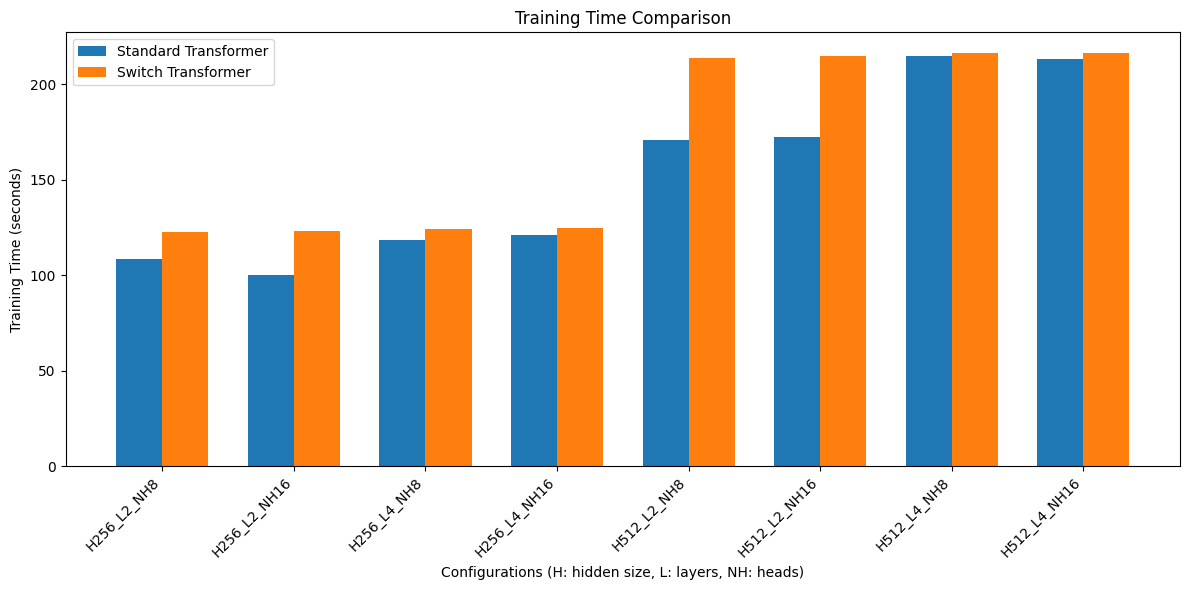

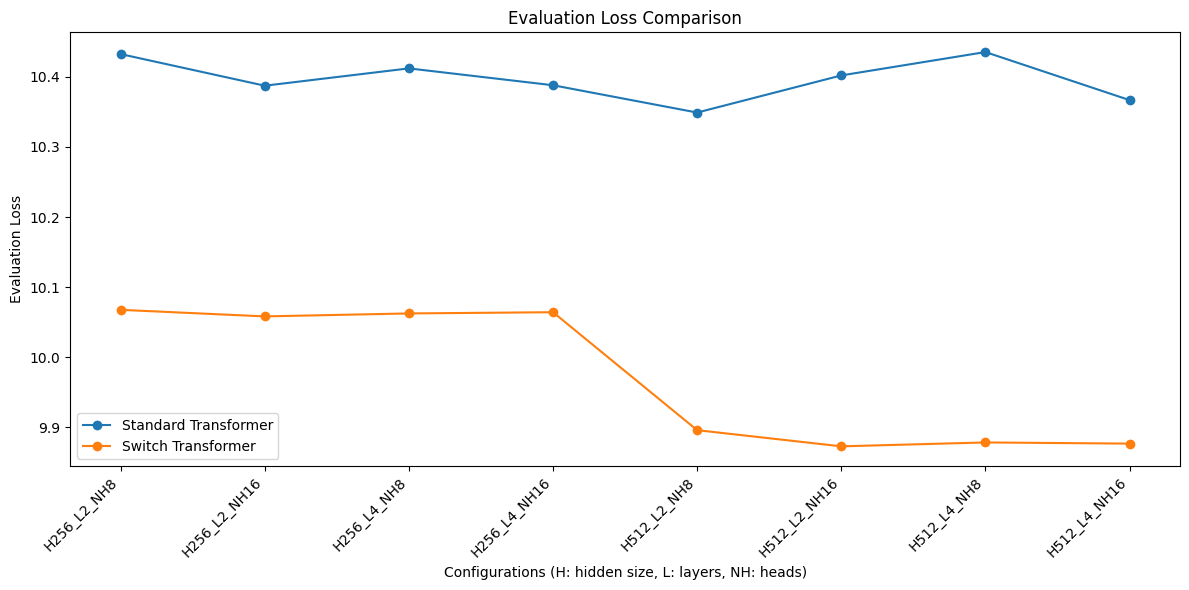

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Data (you can paste your own data here)


# Extract data for plotting
config_labels = [f"H{r['Standard Transformer']['hidden_size']}_L{r['Standard Transformer']['num_layers']}_NH{r['Standard Transformer']['num_heads']}" for r in all_results]
train_times_standard = [r['Standard Transformer']['train_time'] for r in all_results]
train_times_switch = [r['Switch Transformer']['train_time'] for r in all_results]
eval_loss_standard = [r['Standard Transformer']['eval_loss'] for r in all_results]
eval_loss_switch = [r['Switch Transformer']['eval_loss'] for r in all_results]

# Plot training times
plt.figure(figsize=(12, 6))
x = np.arange(len(config_labels))
width = 0.35

plt.bar(x - width/2, train_times_standard, width, label="Standard Transformer")
plt.bar(x + width/2, train_times_switch, width, label="Switch Transformer")
plt.xlabel("Configurations (H: hidden size, L: layers, NH: heads)")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.xticks(x, config_labels, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# Plot evaluation losses
plt.figure(figsize=(12, 6))
plt.plot(config_labels, eval_loss_standard, marker='o', label="Standard Transformer")
plt.plot(config_labels, eval_loss_switch, marker='o', label="Switch Transformer")
plt.xlabel("Configurations (H: hidden size, L: layers, NH: heads)")
plt.ylabel("Evaluation Loss")
plt.title("Evaluation Loss Comparison")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


**------------------------------------------------------------------------------------------------------------------------**

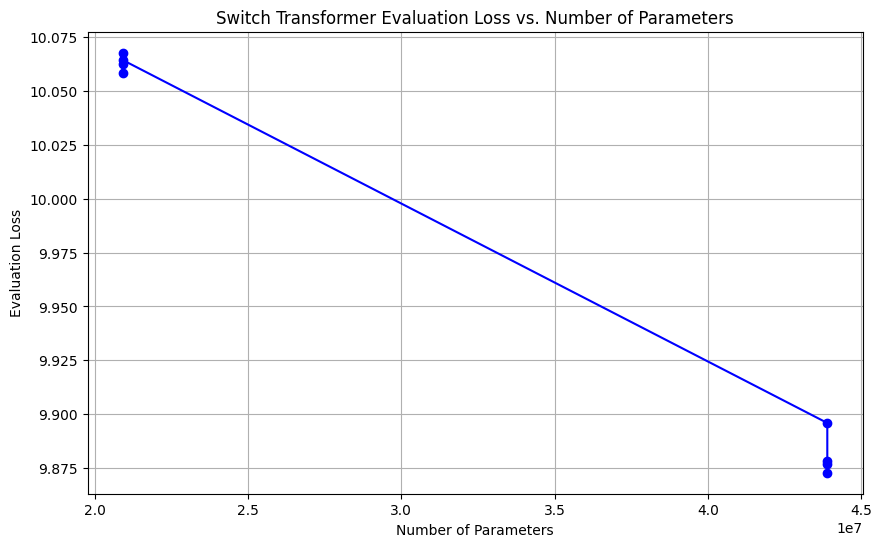

In [43]:
import matplotlib.pyplot as plt

# Extract Switch Transformer evaluation losses and parameter counts from all_results
eval_losses = [result['Switch Transformer']['eval_loss'] for result in all_results]
param_counts = [result['Switch Transformer']['param_count'] for result in all_results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_counts, eval_losses, marker='o', color='b', linestyle='-')
plt.xlabel('Number of Parameters')
plt.ylabel('Evaluation Loss')
plt.title('Switch Transformer Evaluation Loss vs. Number of Parameters')
plt.grid()
plt.show()


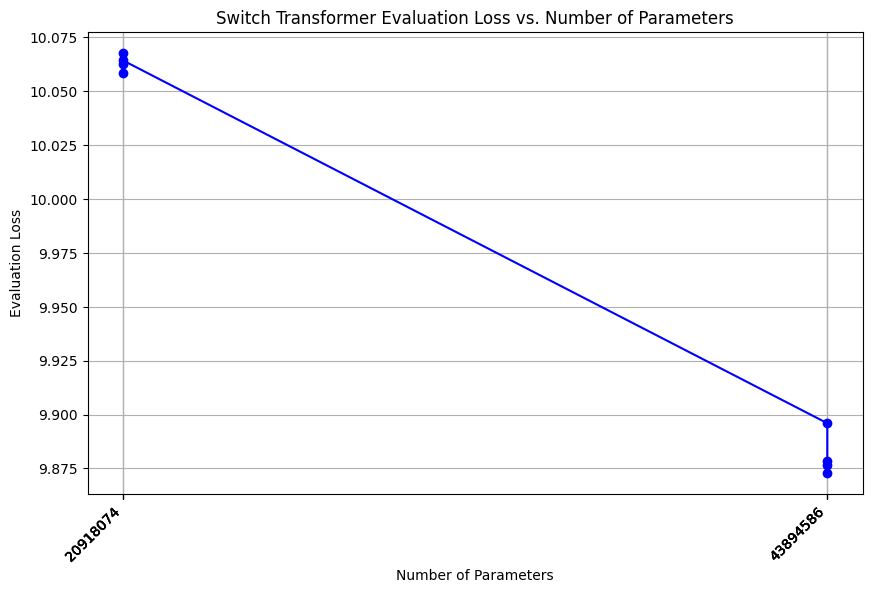

In [45]:
import matplotlib.pyplot as plt

# Extract Switch Transformer evaluation losses and parameter counts from all_results
eval_losses = [result['Switch Transformer']['eval_loss'] for result in all_results]
param_counts = [result['Switch Transformer']['param_count'] for result in all_results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_counts, eval_losses, marker='o', color='b', linestyle='-')
plt.xlabel('Number of Parameters')
plt.ylabel('Evaluation Loss')
plt.title('Switch Transformer Evaluation Loss vs. Number of Parameters')
plt.xticks(ticks=param_counts, labels=[str(p) for p in param_counts])

# Customize the x-axis to be more detailed
plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability
plt.grid()

# Show the plot
plt.show()


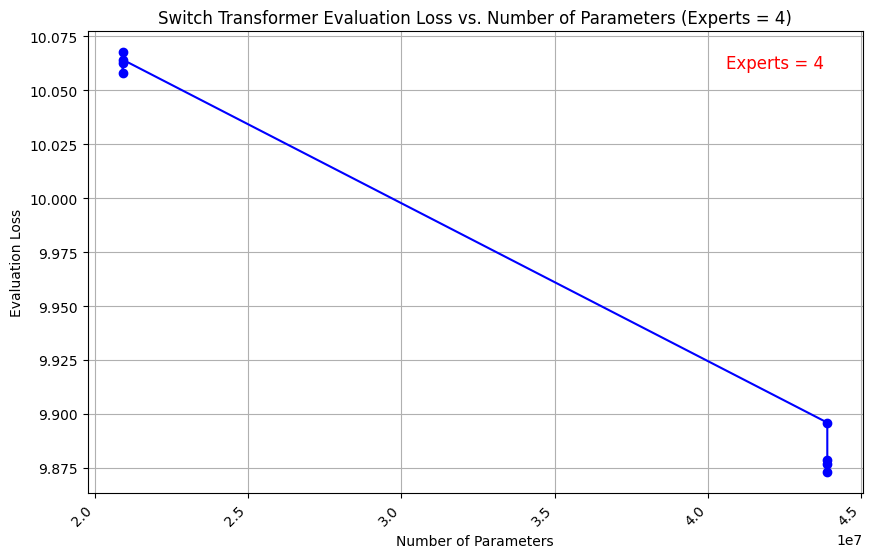

In [46]:
import matplotlib.pyplot as plt

# Extract Switch Transformer evaluation losses and parameter counts from all_results
eval_losses = [result['Switch Transformer']['eval_loss'] for result in all_results]
param_counts = [result['Switch Transformer']['param_count'] for result in all_results]

# Number of experts is fixed at 4
num_experts = 4

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_counts, eval_losses, marker='o', color='b', linestyle='-')
plt.xlabel('Number of Parameters')
plt.ylabel('Evaluation Loss')

# Add the number of experts to the title
plt.title(f'Switch Transformer Evaluation Loss vs. Number of Parameters (Experts = {num_experts})')

# Customize the x-axis to be more detailed
plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability

# Optionally, add a text annotation to the plot (if needed)
plt.text(0.95, 0.95, f'Experts = {num_experts}', transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='top', fontsize=12, color='red')

plt.grid()

# Show the plot
plt.show()


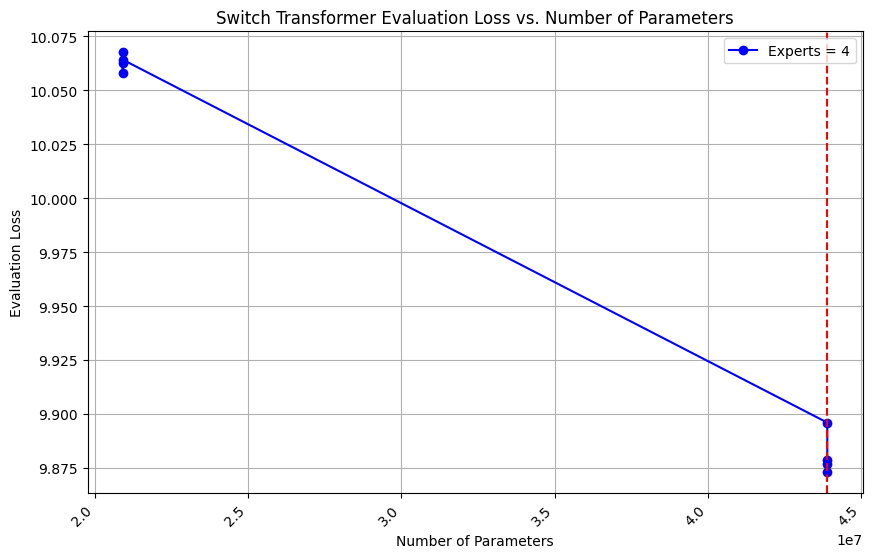

In [47]:
import matplotlib.pyplot as plt

# Extract Switch Transformer evaluation losses and parameter counts from all_results
eval_losses = [result['Switch Transformer']['eval_loss'] for result in all_results]
param_counts = [result['Switch Transformer']['param_count'] for result in all_results]

# Number of experts is fixed at 4
num_experts = 4

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_counts, eval_losses, marker='o', color='b', linestyle='-', label=f'Experts = {num_experts}')
plt.xlabel('Number of Parameters')
plt.ylabel('Evaluation Loss')

# Add the number of experts to the title
plt.title('Switch Transformer Evaluation Loss vs. Number of Parameters')

# Customize the x-axis to be more detailed
plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability

# Add a legend that includes the number of experts
plt.legend(loc='upper right')

# Optionally, add a vertical line to emphasize the number of experts (this is just an aesthetic choice)
plt.axvline(x=param_counts[-1], color='r', linestyle='--', label=f'Experts = {num_experts}')

# Show the plot
plt.grid()
plt.show()


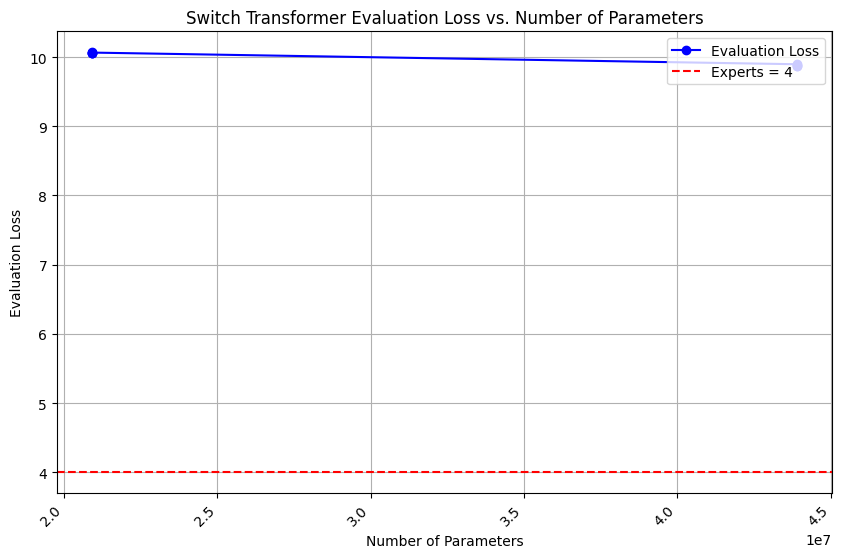

In [48]:
import matplotlib.pyplot as plt

# Extract Switch Transformer evaluation losses and parameter counts from all_results
eval_losses = [result['Switch Transformer']['eval_loss'] for result in all_results]
param_counts = [result['Switch Transformer']['param_count'] for result in all_results]

# Number of experts is fixed at 4
num_experts = 4

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_counts, eval_losses, marker='o', color='b', linestyle='-', label='Evaluation Loss')

# Draw a horizontal line at y=4 for number of experts
plt.axhline(y=num_experts, color='r', linestyle='--', label=f'Experts = {num_experts}')

plt.xlabel('Number of Parameters')
plt.ylabel('Evaluation Loss')
plt.title('Switch Transformer Evaluation Loss vs. Number of Parameters')
plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability
plt.grid()

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.show()


**INCREASE NUMBER OF EXPERTS AND ATEENTION HEADS AND NUMBER OF LAYERS  **

In [49]:
# Define hyperparameter ranges
hidden_sizes = [256, 512]
num_layers = [4, 8]
num_heads = [16, 32]
vocab_size = 30522  # Example vocabulary size for an NLP task
num_experts = 8

hyperparameter_combinations = [
    (h, l, nh) for h in hidden_sizes for l in num_layers for nh in num_heads
]

# Run the scaling test
all_results = []
for h, l, nh in hyperparameter_combinations:
    print(f"\nRunning combination: hidden_size={h}, num_layers={l}, num_heads={nh}")
    results = train_and_evaluate(h, l, nh, vocab_size, num_experts)
    all_results.append(results)

# Print the results
print("\nAll Results:")
for res in all_results:
    print(res)


Running combination: hidden_size=256, num_layers=4, num_heads=16


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Training Standard Transformer with hidden_size=256, num_layers=4, num_heads=16, num_experts=8
Batch 0 inputs shape: torch.Size([32, 50])
Batch 0 targets shape: torch.Size([32, 50])
Completed Standard Transformer: Train Time = 139.64s, Eval Loss = 10.3771, Params = 20918074
Training Switch Transformer with hidden_size=256, num_layers=4, num_heads=16, num_experts=8
Batch 0 inputs shape: torch.Size([32, 50])
Batch 0 targets shape: torch.Size([32, 50])
Completed Switch Transformer: Train Time = 185.17s, Eval Loss = 10.0794, Params = 26178362

Running combination: hidden_size=256, num_layers=4, num_heads=32
Training Standard Transformer with hidden_size=256, num_layers=4, num_heads=32, num_experts=8
Batch 0 inputs shape: torch.Size([32, 50])
Batch 0 targets shape: torch.Size([32, 50])
Completed Standard Transformer: Train Time = 144.26s, Eval Loss = 10.3996, Params = 20918074
Training Switch Transformer with hidden_size=256, num_layers=4, num_heads=32, num_experts=8
Batch 0 inputs shape: to

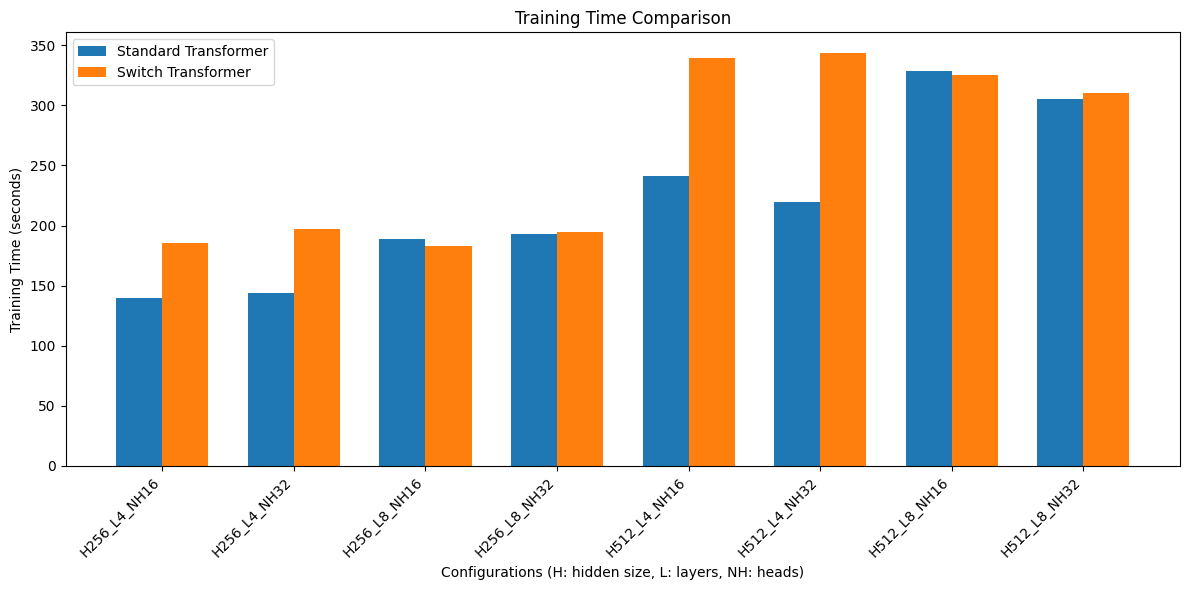

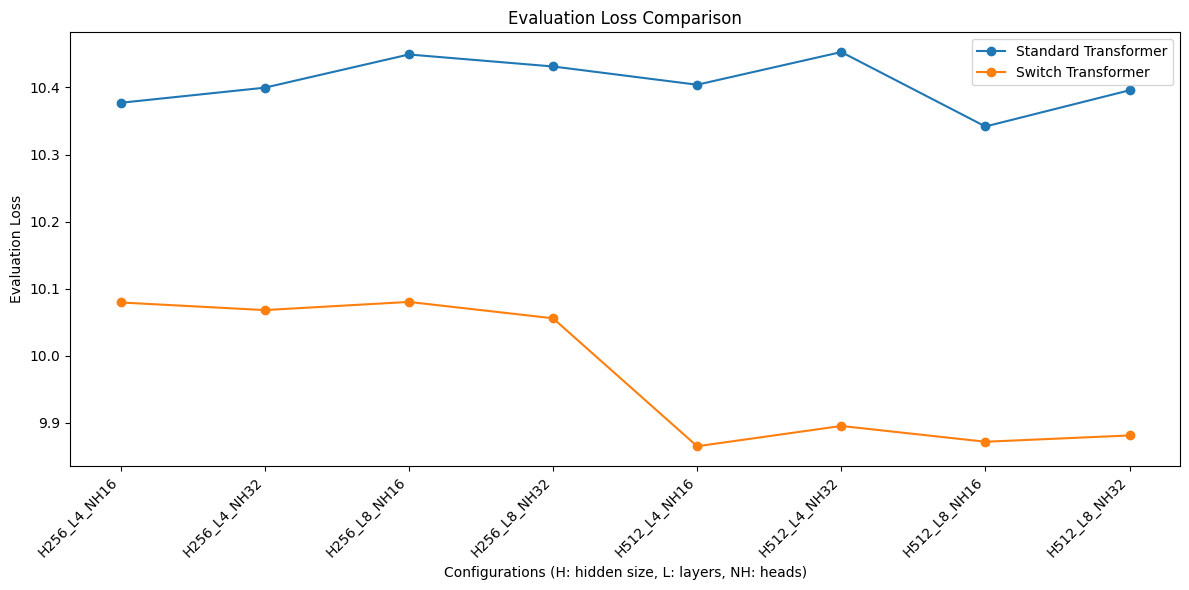

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Data (you can paste your own data here)


# Extract data for plotting
config_labels = [f"H{r['Standard Transformer']['hidden_size']}_L{r['Standard Transformer']['num_layers']}_NH{r['Standard Transformer']['num_heads']}" for r in all_results]
train_times_standard = [r['Standard Transformer']['train_time'] for r in all_results]
train_times_switch = [r['Switch Transformer']['train_time'] for r in all_results]
eval_loss_standard = [r['Standard Transformer']['eval_loss'] for r in all_results]
eval_loss_switch = [r['Switch Transformer']['eval_loss'] for r in all_results]

# Plot training times
plt.figure(figsize=(12, 6))
x = np.arange(len(config_labels))
width = 0.35

plt.bar(x - width/2, train_times_standard, width, label="Standard Transformer")
plt.bar(x + width/2, train_times_switch, width, label="Switch Transformer")
plt.xlabel("Configurations (H: hidden size, L: layers, NH: heads)")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.xticks(x, config_labels, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# Plot evaluation losses
plt.figure(figsize=(12, 6))
plt.plot(config_labels, eval_loss_standard, marker='o', label="Standard Transformer")
plt.plot(config_labels, eval_loss_switch, marker='o', label="Switch Transformer")
plt.xlabel("Configurations (H: hidden size, L: layers, NH: heads)")
plt.ylabel("Evaluation Loss")
plt.title("Evaluation Loss Comparison")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
for results in all_results:
    print("Hyperparameters:")
    print(f"  Hidden Size: {results['Standard Transformer']}")
    print(f"  Number of Layers: {results['Standard Transformer']}")
    print(f"  Number of Heads: {results['Standard Transformer']}")
    print(f"  Number of Experts: {results['Switch Transformer']}")

    print("\nStandard Transformer:")
    print(results['Standard Transformer'])

    print("\nSwitch Transformer:")
    print(results['Switch Transformer'])

    print("-" * 80)

Hyperparameters:
  Hidden Size: {'hidden_size': 256, 'num_layers': 4, 'num_heads': 16, 'num_experts': None, 'train_time': 139.64122033119202, 'eval_loss': 10.377091974020004, 'param_count': 20918074}
  Number of Layers: {'hidden_size': 256, 'num_layers': 4, 'num_heads': 16, 'num_experts': None, 'train_time': 139.64122033119202, 'eval_loss': 10.377091974020004, 'param_count': 20918074}
  Number of Heads: {'hidden_size': 256, 'num_layers': 4, 'num_heads': 16, 'num_experts': None, 'train_time': 139.64122033119202, 'eval_loss': 10.377091974020004, 'param_count': 20918074}
  Number of Experts: {'hidden_size': 256, 'num_layers': 4, 'num_heads': 16, 'num_experts': 8, 'train_time': 185.17166256904602, 'eval_loss': 10.07938838005066, 'param_count': 26178362}

Standard Transformer:
{'hidden_size': 256, 'num_layers': 4, 'num_heads': 16, 'num_experts': None, 'train_time': 139.64122033119202, 'eval_loss': 10.377091974020004, 'param_count': 20918074}

Switch Transformer:
{'hidden_size': 256, 'num_la

**DIFFRENCE BETWEEN SWITCH TRANSFORMERS ""

In [ ]:
import torch
import torch.nn as nn
import time
from torch.utils.data import DataLoader, Dataset

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example Dataset
class SimpleDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=50, vocab_size=30522):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.data = [
            {
                'input_ids': torch.randint(0, vocab_size, (seq_length,)),
                'labels': torch.randint(0, vocab_size, (seq_length,))
            }
            for _ in range(num_samples)
        ]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# DataLoader
def get_data_loader(batch_size=32):
    dataset = SimpleDataset()
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Transformer Model
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src):
        embedded = self.embedding(src)  # (batch_size, seq_length, d_model)
        embedded = embedded.permute(1, 0, 2)  # (seq_length, batch_size, d_model)
        transformer_out = self.transformer_encoder(embedded)  # (seq_length, batch_size, d_model)
        output = self.fc_out(transformer_out)  # (seq_length, batch_size, tgt_vocab_size)
        return output.permute(1, 0, 2)  # (batch_size, seq_length, tgt_vocab_size)

# Switch Transformer Model
class SwitchTransformer(nn.Module):
    def __init__(self, num_experts, hidden_size, num_heads):
        super(SwitchTransformer, self).__init__()
        self.num_experts = num_experts
        self.embedding = nn.Embedding(30522, hidden_size)
        self.expert_layers = nn.ModuleList([nn.TransformerEncoderLayer(hidden_size, num_heads) for _ in range(num_experts)])
        self.fc_out = nn.Linear(hidden_size, 30522)

    def forward(self, src):
        embedded = self.embedding(src)  # (batch_size, seq_length, hidden_size)
        embedded = embedded.permute(1, 0, 2)  # (seq_length, batch_size, hidden_size)

        # Simple routing: round-robin
        expert_outputs = []
        for i, layer in enumerate(self.expert_layers):
            expert_output = layer(embedded)  # (seq_length, batch_size, hidden_size)
            expert_outputs.append(expert_output)

        # Aggregate expert outputs (e.g., average)
        aggregated = torch.mean(torch.stack(expert_outputs), dim=0)  # (seq_length, batch_size, hidden_size)
        output = self.fc_out(aggregated)  # (seq_length, batch_size, vocab_size)
        return output.permute(1, 0, 2)  # (batch_size, seq_length, vocab_size)

# Utility function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Evaluation function
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)
            targets = batch['labels'].to(device)
            outputs = model(inputs)
            # Reshape for loss calculation
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
            total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    return average_loss


# Training and Evaluation Function
def train_and_evaluate(hidden_size, num_layers, num_heads, vocab_size, num_experts=4, epochs=1):
    # Get the DataLoader
    data_loader = get_data_loader(batch_size=32)

    # Initialize models
    standard_transformer = Transformer(
        src_vocab_size=vocab_size,
        tgt_vocab_size=vocab_size,
        d_model=hidden_size,
        num_heads=num_heads,
        num_layers=num_layers
    ).to(device)

    switch_transformer = SwitchTransformer(
        num_experts=num_experts,
        hidden_size=hidden_size,
        num_heads=num_heads
    ).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer_standard = torch.optim.Adam(standard_transformer.parameters())
    optimizer_switch = torch.optim.Adam(switch_transformer.parameters())

    results = {"Standard Transformer": {}, "Switch Transformer": {}}

    # Training and evaluation loop
    for model, optimizer, name in [
        (standard_transformer, optimizer_standard, "Standard Transformer"),
        (switch_transformer, optimizer_switch, "Switch Transformer")
    ]:
        print(f"Training {name} with hidden_size={hidden_size}, num_layers={num_layers}, num_heads={num_heads}, num_experts={num_experts}")
        start_time = time.time()
        model.train()

        # Train for the specified number of epochs
        for epoch in range(epochs):
            for batch_idx, batch in enumerate(data_loader):
                inputs = batch['input_ids'].to(device)
                targets = batch['labels'].to(device)

                # Debugging prints
                if batch_idx == 0:
                    print(f"Batch {batch_idx} inputs shape: {inputs.shape}")
                    print(f"Batch {batch_idx} targets shape: {targets.shape}")

                # Forward pass
                optimizer.zero_grad()
                outputs = model(inputs)
                # Modify the loss calculation line
                loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.view(-1))
                # Backward pass
                loss.backward()
                optimizer.step()

        # Measure time and performance
        train_time = time.time() - start_time
        eval_loss = evaluate_model(model, data_loader, criterion, device)

        # Get the parameter count
        param_count = count_parameters(model)

        # Log results
        results[name] = {
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "num_heads": num_heads,
            "num_experts": num_experts if name == "Switch Transformer" else None,
            "train_time": train_time,
            "eval_loss": eval_loss,
            "param_count": param_count,
        }

        print(f"Completed {name}: Train Time = {train_time:.2f}s, Eval Loss = {eval_loss:.4f}, Params = {param_count}")

    return results

# Define hyperparameter ranges
hidden_sizes = [256, 512]
num_layers = [2, 4]
num_heads = [8, 16]
vocab_size = 30522  # Example vocabulary size for an NLP task
num_experts = 4

hyperparameter_combinations = [
    (h, l, nh) for h in hidden_sizes for l in num_layers for nh in num_heads
]

# Run the scaling test
all_results = []
for h, l, nh in hyperparameter_combinations:
    print(f"\nRunning combination: hidden_size={h}, num_layers={l}, num_heads={nh}")
    results = train_and_evaluate(h, l, nh, vocab_size, num_experts)
    all_results.append(results)

# Print the results
print("\nAll Results:")
for res in all_results:
    print(res)


**Test**